Purpose of this notebook:

1. Enable quick manual segmentation of large TIF images containing multiple tiles in x-y and multiple z-planes, in a single channel
2. Create a table of cells X ROIs also containing information about the location of the cell in vivo (within a particular FOV)
3. Allow each cell to have ROIs in multiple z planes
4. Work with single image stitched in x-y if possible
5. Use ROIs from one channel to calculate intensity in other channels and produce histogram

# Setup

In [1]:
%gui qt5 

In [2]:
# Imports in alphabetical order of module name

from IPython.display import display
from PIL import Image, ImageDraw
import napari
import numpy as np
import pickle as pkl
import matplotlib.path as mpltpath
import matplotlib.pyplot as plt
import cv2


# Load images

## Segmentation channel (Ndnf)

In [3]:
## Specify images to load

folder = 'Z:\HCR\HCR_9.13\S1_546_647_dapi_514_z-stack_tiles_2019_09_16__22_04_08-Rotate 2D-01'

base_filename = 'S1_546_647_dapi_514_z-stack_tiles_2019_09_16__22_04_08-Rotate 2D-01_z'

plane_nos = range(1, 19)
n = len(plane_nos)
print('Number of planes: {0}'.format(n))

img = Image.open('{0}\{1}{2}c1_ORG.tif'.format(folder, base_filename, str(plane_nos[0]).zfill(2)))
h = img.height
w = img.width
print('Size of image in pixels: {0} X {1} X {2}'.format(n, h, w))

Number of planes: 18
Size of image in pixels: 18 X 1893 X 7423


In [4]:
# Create 4D array to store images
im_array = np.zeros([n, h, w])

for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c1_ORG.tif'.format(folder, base_filename, str(p).zfill(2)))
    try:
        im_array[i, :, :] = np.array(img)
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue


Size of image in pixels: 18 X 1893 X 7423
Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18


## Channels to measure (Egln3 + Npy)

### Without background subtraction

In [7]:
im_array_egln3 = np.zeros([n, h, w])
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c2_ORG.tif'.format(folder, base_filename,str(p).zfill(2)))
    try:
        im_array_egln3[i, :, :] = np.array(img)
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_egln3 = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Plane 4 could not be loaded
Size of plane 1893 in pixels: 1893 X 7423


AttributeError: 'range' object has no attribute 'remove'

In [45]:
im_array_npy = np.zeros([n, h, w])
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c4_ORG.tif'.format(folder, base_filename,str(p).zfill(2)))
    try:
        im_array_npy[i, :, :] = np.array(img)
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_npy = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18


### With background subtraction

In [64]:
im_array_egln3 = np.zeros([n, h, w])
img_file = 'S1_647_c2_egln3_background_subtracted'
img = Image.open('{0}\{1}.tif'.format(folder, img_file))
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    try:
        img.seek(p - 1)
        im_array_egln3[i, :, :] = np.array(img)
        
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_egln3 = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18


In [65]:
im_array_npy = np.zeros([n, h, w])
img_file = 'S1_514_c4_npy_background_subtracted'
img = Image.open('{0}\{1}.tif'.format(folder, img_file))
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    try:
        img.seek(p - 1)
        im_array_npy[i, :, :] = np.array(img)
        
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_npy = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18


# Segmentation

## Data structure to store masks

In [4]:
class Cell:
    n_cells = 1
    cell_data = {}
    
    def __init__(self, cell_no):
        
        self.cell_no = cell_no
        self.z_planes = []
        self.no_planes = 0
        self.masks = {}
        self.c_vals = np.zeros(1)
        print('Cell #{0} created'.format(Cell.n_cells))
        Cell.n_cells += 1
        
    def add_mask(self, z_plane, mask):
        self.z_planes.append(z_plane)
        self.no_planes += 1
        self.masks[z_plane] = mask
            
    def save_cell(self):
        Cell.cell_data[self.cell_no] = {'cell_id': self.cell_no,
                                 'z_planes': self.z_planes,
                                 'masks': self.masks,
                                 'no_planes': self.no_planes,
                                 'c_vals':self.c_vals}
        
print('Cell.n_cells = {0}'.format(Cell.n_cells))

Cell.n_cells = 1


## Load masks if they already exist

In [5]:
# Load masks if they already exist
save_loc = 'Z:\HCR\HCR_9.13'
save_file = 'S1_data.pkl'
try:
    with open('{0}\{1}'.format(save_loc, save_file), 'rb') as f:
        Cell.cell_data = pkl.load(f)
        indices = list(Cell.cell_data.keys())
        if not np.max(indices) == len(indices):
            print('Re-numbering cells to be consecutive')
            Cell.cell_data_temp = {}
            for i in range(len(indices)):
                Cell.cell_data_temp[i + 1] = Cell.cell_data[indices[i]]
                Cell.cell_data_temp[i + 1]['cell_id'] = i + 1
            Cell.cell_data = Cell.cell_data_temp 
            with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
                pkl.dump(Cell.cell_data, f)
    Cell.n_cells = len(indices)
    print('{0} cells found'.format(Cell.n_cells))
except:
    Cell.cell_data = {}
    print('No data found')

195 cells found


## Render image in napari GUI

In [27]:
# Open image in napari viewer - each channel as a separate layer 
viewer = napari.Viewer()

viewer.add_image(im_array[:, :, :], name = 'Channel {0}'.format(i + 1), colormap = 'viridis', 
                     interpolation = 'nearest')
    
seg_channel = 0
viewer.add_shapes([], name = 'masks', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)

# Add existing masks
indices = list(Cell.cell_data.keys())
mask_layer = viewer.layers['masks']
for cell in indices:
    plane = Cell.cell_data[cell]['z_planes'][0]
    mask = Cell.cell_data[cell]['masks'][plane]
    mask_layer.add(mask, shape_type = 'polygon', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)

# Keybinding functions

@viewer.bind_key('n')
def new_cell(viewer):
    global cell1 
    cell1 = Cell(Cell.n_cells)

@viewer.bind_key('m')
def add_mask(viewer):
    seg_layer = viewer.layers[seg_channel]
    z_plane = seg_layer.coordinates[0]
    mask = viewer.layers['masks'].data[-1]
    cell1.add_mask(z_plane, mask)
    
@viewer.bind_key('k')
def save_cell(viewer):
    cell1.save_cell()
    
@viewer.bind_key('Control-s')
def save_all(viewer):
    with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
                pkl.dump(Cell.cell_data, f)

C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vis

C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vis

C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vis

## View masks created

In [40]:
Cell.cell_data[list(Cell.cell_data.keys())[-1]]

{'cell_id': 174,
 'z_planes': [15, 16, 15],
 'masks': {15: array([[ 196.46482335, 3114.69213643],
         [ 194.29608304, 3117.22233346],
         [ 192.48879945, 3119.93325885],
         [ 191.22370093, 3123.36709767],
         [ 195.74190991, 3128.42749173],
         [ 200.44084725, 3127.70457829],
         [ 202.4288592 , 3124.63219619],
         [ 203.15177264, 3120.11398721],
         [ 202.97104428, 3117.22233346],
         [ 202.06740248, 3114.33067971],
         [ 201.16376069, 3112.52339612],
         [ 200.80230397, 3112.88485284]]),
  16: array([[1236.91264876,  747.18821651],
         [1240.03181461,  757.43690431],
         [1246.04734875,  763.22964089],
         [1248.49812192,  763.22964089],
         [1251.84008533,  756.10011894],
         [1251.61728777,  750.0845848 ],
         [1250.72609753,  744.9602409 ],
         [1248.94371704,  742.06387261],
         [1246.04734875,  741.84107505],
         [1243.37377802,  741.61827749],
         [1239.14062437,  741.84107

In [51]:
len(Cell.cell_data.keys())

196

In [48]:
cell1.masks

{16: array([[ 526.53627884, 7092.98748801],
        [ 531.21502762, 7107.69212703],
        [ 537.23056176, 7108.58331727],
        [ 539.68133493, 7104.57296118],
        [ 539.01294225, 7098.33462947],
        [ 536.33937152, 7092.09629777],
        [ 532.55181299, 7088.08594167],
        [ 529.87824226, 7086.74915631],
        [ 528.54145689, 7086.97195387],
        [ 528.54145689, 7086.97195387]]),
 17: array([[ 523.41711299, 7088.97713192],
        [ 522.74872031, 7096.32945143],
        [ 527.87306421, 7104.57296118],
        [ 533.22020567, 7109.0289124 ],
        [ 538.56734713, 7109.47450752],
        [ 540.79532274, 7109.47450752],
        [ 541.24091786, 7101.23099777],
        [ 540.79532274, 7094.10147582],
        [ 536.56216908, 7090.09111972],
        [ 533.66580079, 7087.19475143],
        [ 529.43264713, 7086.08076363],
        [ 527.42746909, 7085.63516851],
        [ 527.42746909, 7085.63516851]])}

## Sanity checks

In [55]:
# Check number of masks per cell, and variance of mask centers
indices = list(Cell.cell_data.keys())
n_planes = np.zeros(len(indices)).astype(int)
var_masks = np.zeros([len(indices), 2])

if not np.max(indices) == len(indices):
    print('Re-numbering cells to be consecutive')
    Cell.cell_data_temp = {}
    for i in range(len(indices)):
        Cell.cell_data_temp[i + 1] = Cell.cell_data[indices[i]]
        Cell.cell_data_temp[i + 1]['cell_id'] = i + 1
    Cell.cell_data = Cell.cell_data_temp 
    with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
        pkl.dump(Cell.cell_data, f)
        
for i in range(len(indices)):
    z_planes = Cell.cell_data[i + 1]['z_planes']
    n_planes[i] = len(z_planes)
    masks = Cell.cell_data[i + 1]['masks']
    centers = np.zeros([n_planes[i], 2])
    for j in range(n_planes[i]):
        centers[j, 0] = np.mean(masks[z_planes[j]][:, 0])
        centers[j, 1] = np.mean(masks[z_planes[j]][:, 1])
    var_masks[i, 0] = np.var(centers[:, 0])
    var_masks[i, 1] = np.var(centers[:, 1])

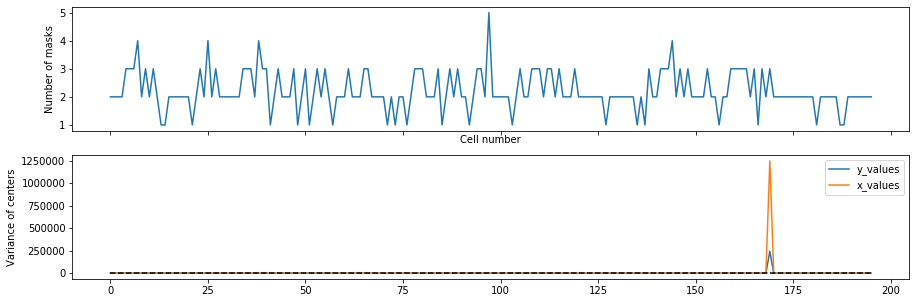

In [56]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = [15, 5])
ax[0].plot(n_planes)
ax[0].set_xlabel('Cell number')
ax[0].set_ylabel('Number of masks')
ax[1].plot(var_masks[:, 0], label = 'y_values')
ax[1].plot(var_masks[:, 1], label = 'x_values')
ax[1].set_ylabel('Variance of centers')
ax[1].plot(range(len(indices)), np.ones(len(indices))*8, '--', color = 'k')
ax[1].legend()

In [57]:
ind = np.nonzero(var_masks > 50)[0]

In [60]:
ind

array([169, 169], dtype=int64)

In [59]:
cell_no = ind[0] + 1
masks = Cell.cell_data[cell_no]['masks']
masks

{15: array([[ 196.46482335, 3114.69213643],
        [ 194.29608304, 3117.22233346],
        [ 192.48879945, 3119.93325885],
        [ 191.22370093, 3123.36709767],
        [ 195.74190991, 3128.42749173],
        [ 200.44084725, 3127.70457829],
        [ 202.4288592 , 3124.63219619],
        [ 203.15177264, 3120.11398721],
        [ 202.97104428, 3117.22233346],
        [ 202.06740248, 3114.33067971],
        [ 201.16376069, 3112.52339612],
        [ 200.80230397, 3112.88485284]]),
 16: array([[1236.91264876,  747.18821651],
        [1240.03181461,  757.43690431],
        [1246.04734875,  763.22964089],
        [1248.49812192,  763.22964089],
        [1251.84008533,  756.10011894],
        [1251.61728777,  750.0845848 ],
        [1250.72609753,  744.9602409 ],
        [1248.94371704,  742.06387261],
        [1246.04734875,  741.84107505],
        [1243.37377802,  741.61827749],
        [1239.14062437,  741.84107505]])}

In [63]:
Cell.cell_data.pop(cell_no)

{'cell_id': 170,
 'z_planes': [15, 16, 15],
 'masks': {15: array([[ 196.46482335, 3114.69213643],
         [ 194.29608304, 3117.22233346],
         [ 192.48879945, 3119.93325885],
         [ 191.22370093, 3123.36709767],
         [ 195.74190991, 3128.42749173],
         [ 200.44084725, 3127.70457829],
         [ 202.4288592 , 3124.63219619],
         [ 203.15177264, 3120.11398721],
         [ 202.97104428, 3117.22233346],
         [ 202.06740248, 3114.33067971],
         [ 201.16376069, 3112.52339612],
         [ 200.80230397, 3112.88485284]]),
  16: array([[1236.91264876,  747.18821651],
         [1240.03181461,  757.43690431],
         [1246.04734875,  763.22964089],
         [1248.49812192,  763.22964089],
         [1251.84008533,  756.10011894],
         [1251.61728777,  750.0845848 ],
         [1250.72609753,  744.9602409 ],
         [1248.94371704,  742.06387261],
         [1246.04734875,  741.84107505],
         [1243.37377802,  741.61827749],
         [1239.14062437,  741.84107

In [64]:
with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
    pkl.dump(Cell.cell_data, f)

## Manual vs semi-automated segmentation

### Load images for blob detection

In [6]:
im_array_blob = np.zeros([n, h, w])
img_file = 'S1_546_c1_ndnf_binary'
img = Image.open('{0}\{1}.tif'.format(folder, img_file))
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    try:
        img.seek(p - 1)
        im_array_blob[i, :, :] = np.array(img)
        
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_egln3 = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18


### Find blobs

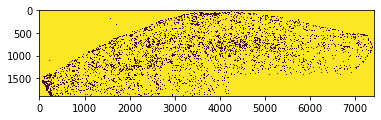

In [56]:
im_blob = cv2.imread('{0}\{1}.tif'.format(folder, img_file), 0)
plt.figure()
plt.imshow(im_blob)

In [57]:
# Set up the detector with area filter.
params = cv2.SimpleBlobDetector_Params() 
params.filterByCircularity = False
params.filterByColor = False
params.filterByConvexity = False
params.filterByInertia = False

um_per_px = 0.19

min_diameter = 5 # in um
max_diameter = 15 # in um

min_diameter /= um_per_px
max_diameter /= um_per_px

params.minArea = (min_diameter/2)*(min_diameter/2)*np.pi
params.maxArea = (max_diameter/2)*(max_diameter/2)*np.pi
params.filterByArea = True

detector = cv2.SimpleBlobDetector_create(params)

In [61]:
keypoints = detector.detect(im_blob)
print('{0} blobs detected'.format(len(keypoints)))
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(im_blob, keypoints, np.array([]), (0,0,255), 
                                      cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imshow("Keypoints", im_with_keypoints)

329 blobs detected


In [63]:
kp = np.array(keypoints)

In [75]:
keypoints[0]

<KeyPoint 0000000017D7EF00>

# Calculate intensity in other channels

In [48]:
# Only run once:
xv = range(w)
yv = range(h)
coord_array = np.array(np.meshgrid(xv, yv))

points = np.zeros([h*w, 2])
p = 0
for i in range(h):
    for j in range(w):
        points[p, 1] = coord_array[0, i, j]
        points[p, 0] = coord_array[1, i, j]
        p += 1

In [59]:
# ~7.5 min run time for 195 cells
no_cells = len(Cell.cell_data.keys())
avg_intensity_egln3 = np.zeros(no_cells)
avg_intensity_npy = np.zeros(no_cells)

for cell in range(no_cells):
    
    if np.mod(cell, 10) == 0:
        print('Cell {0}'.format(cell))
    cell_no = cell + 1
    cell_dict = Cell.cell_data[cell_no]
    masks = cell_dict['masks']
    z_planes = cell_dict['z_planes']

    intensity_egln3 = np.zeros(cell_dict['no_planes'])
    intensity_npy = np.zeros(cell_dict['no_planes'])
    
    i = 0
    for plane in z_planes:

        vertices = masks[plane]
        path = mpltpath.Path(vertices)
        mask = path.contains_points(points)
        mask = np.reshape(mask, [h, w])

        intensity_egln3[i] = np.mean(im_array_egln3[plane, mask])
        intensity_npy[i] = np.mean(im_array_npy[plane, mask])
        i += 1
    
    avg_intensity_egln3[cell] = np.mean(intensity_egln3)
    avg_intensity_npy[cell] = np.mean(intensity_npy)


Cell 0
Cell 10
Cell 20
Cell 30
Cell 40
Cell 50
Cell 60
Cell 70
Cell 80
Cell 90
Cell 100
Cell 110
Cell 120
Cell 130
Cell 140
Cell 150
Cell 160
Cell 170
Cell 180
Cell 190


In [60]:
plt.hist(avg_intensity_egln3/np.nanmax(avg_intensity_egln3), 50)
plt.hist(avg_intensity_npy/np.nanmax(avg_intensity_npy), 50)

(array([ 3.,  3.,  3., 11., 45., 45., 31., 21.,  7.,  7.,  4.,  6.,  1.,
         2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.07679874, 0.09526277, 0.11372679, 0.13219082, 0.15065484,
        0.16911887, 0.18758289, 0.20604692, 0.22451094, 0.24297497,
        0.26143899, 0.27990302, 0.29836704, 0.31683107, 0.33529509,
        0.35375912, 0.37222315, 0.39068717, 0.4091512 , 0.42761522,
        0.44607925, 0.46454327, 0.4830073 , 0.50147132, 0.51993535,
        0.53839937, 0.5568634 , 0.57532742, 0.59379145, 0.61225547,
        0.6307195 , 0.64918352, 0.66764755, 0.68611157, 0.7045756 ,
        0.72303962, 0.74150365, 0.75996767, 0.7784317 , 0.79689572,
        0.81535975, 0.83382377, 0.8522878 , 0.87075182, 0.88921585,
        0.90767987, 0.9261439 , 0.94460792, 0.96307195, 0.98153597,
        1.        ]),
 <a list of 50

In [836]:
avg_intensity

array([24.95022124, 40.51698552, 29.09375251, 29.70655193, 34.28772759,
       26.79298246, 32.11151902, 36.66856214, 31.12916451, 30.94487015,
       31.73982033, 43.42839613, 32.75322324, 35.283061  , 51.98990961,
       31.53225302, 40.76069519, 41.11062645, 40.17823601, 37.93169793,
       53.76939491, 42.54205998, 38.89276079, 35.80030759, 29.70721714,
       31.29138233, 26.49753248, 33.4169647 , 48.89624381, 35.60775862,
       37.37936089, 40.91992248, 38.84522526, 39.96567944, 38.72161887,
       36.22450535, 31.1216872 , 32.1789749 , 37.56818182, 31.7029703 ,
       25.12078545, 31.4352518 , 32.83067422, 29.86585859, 28.95391335,
       25.38526056, 25.26495726, 17.05158859, 32.95391705, 29.29847772,
       27.65829146, 29.2310909 , 29.20095163, 26.92653061, 24.15262701,
       27.38459205, 23.84102183, 27.70256569, 28.7169158 , 27.32855492,
       24.42166442, 29.33239191, 37.91411043, 29.01273972, 22.71582282,
       29.10530973, 25.72648526, 31.79910714, 31.79378318, 36.26

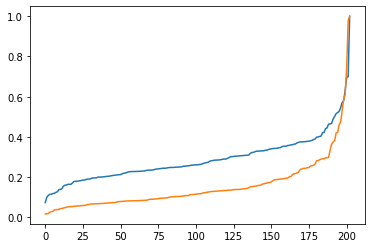

In [26]:
plt.plot(np.sort(avg_intensity_egln3)/np.nanmax(avg_intensity_egln3))
plt.plot(np.sort(avg_intensity_npy)/np.nanmax(avg_intensity_npy))

In [66]:
plt.scatter(avg_intensity_egln3/np.max(avg_intensity_egln3), avg_intensity_npy/np.max(avg_intensity_npy), color = 'k', marker = 'o',
           alpha = 0.2)


plt.xlabel('Relative expression of Egln3')
plt.ylabel('Relative expression of Npy')

Text(0, 0.5, 'Relative expression of Npy')

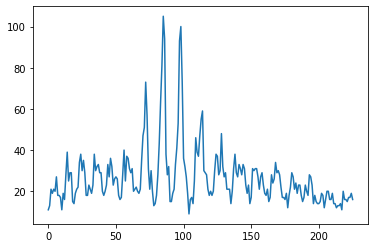

In [801]:
plt.plot(layer.data[plane, mask])

(0, 100)

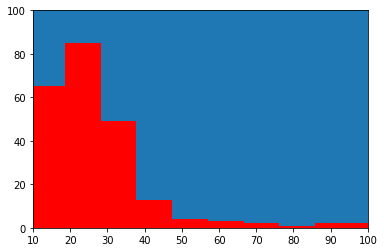

In [807]:
fig = plt.figure()
plt.hist(np.reshape(layer.data[plane, :, :], [-1]), 100)
plt.hist(layer.data[plane, mask], color = 'r')
plt.xlim(10, 100)
plt.ylim(0, 100)

In [806]:
layer.data[plane, mask]

array([ 11.,  13.,  21.,  19.,  21.,  20.,  27.,  18.,  18.,  17.,  11.,
        19.,  16.,  28.,  39.,  25.,  29.,  29.,  15.,  14.,  19.,  21.,
        22.,  34.,  38.,  30.,  35.,  29.,  18.,  18.,  23.,  21.,  19.,
        23.,  38.,  30.,  32.,  33.,  29.,  29.,  20.,  18.,  20.,  23.,
        33.,  27.,  36.,  32.,  23.,  26.,  27.,  26.,  18.,  16.,  17.,
        28.,  40.,  25.,  37.,  36.,  31.,  29.,  31.,  20.,  21.,  22.,
        20.,  19.,  21.,  35.,  47.,  51.,  73.,  57.,  31.,  21.,  30.,
        20.,  13.,  14.,  18.,  28.,  43.,  63.,  81., 105.,  94.,  38.,
        28.,  32.,  15.,  15.,  19.,  21.,  33.,  41.,  53.,  93., 100.,
        73.,  36.,  32.,  27.,  19.,   9.,  16.,  17.,  14.,  25.,  46.,
        39.,  37.,  47.,  55.,  59.,  30.,  29.,  28.,  21.,  18.,  20.,
        18.,  20.,  30.,  38.,  37.,  28.,  30.,  48.,  32.,  27.,  29.,
        21.,  21.,  21.,  14.,  20.,  31.,  38.,  29.,  27.,  33.,  31.,
        28.,  33.,  31.,  23.,  19.,  23.,  14.,  1

# View saved masks

In [130]:
with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
    pkl.dump(Cell.cell_data, f)

In [142]:
indices = list(Cell.cell_data.keys())
Cell.cell_data[indices[-1]]

{'cell_id': 218,
 'z_planes': [25],
 'masks': {25: array([[1408.69156795,  200.9151809 ],
         [1411.07489781,  207.42961584],
         [1413.93489363,  208.54183643],
         [1417.27155543,  208.06517046],
         [1419.17821932,  206.31739524],
         [1420.76710589,  203.29851075],
         [1422.03821514,  200.75629224],
         [1421.0848832 ,  198.84962835],
         [1419.65488529,  196.62518716],
         [1418.38377603,  195.67185521],
         [1416.95377812,  195.67185521],
         [1414.09378229,  196.78407581],
         [1413.299339  ,  196.78407581],
         [1413.299339  ,  196.78407581]])},
 'no_planes': 1,
 'c_vals': array([0.])}

In [141]:
cell1.masks

{19: array([[885.22584202, 698.45195199],
        [880.83473574, 699.70655379],
        [879.2664835 , 700.75205528],
        [877.28003066, 703.57490931],
        [875.50267812, 705.6659123 ],
        [873.09802469, 709.22061738],
        [873.30712499, 711.93892126],
        [875.81632857, 712.87987261],
        [878.53463246, 713.82082395],
        [879.99833455, 712.46167201],
        [881.77568709, 710.78886962],
        [883.55303963, 708.48876633],
        [885.43494232, 704.93406126],
        [886.89864441, 703.05215857],
        [887.7350456 , 700.12475438],
        [887.83959575, 699.18380304]]),
 20: array([[884.18034052, 698.97470274],
        [881.04383604, 700.75205528],
        [877.48913096, 702.11120722],
        [874.14352618, 707.02506424],
        [872.47072379, 710.68431947],
        [874.35262648, 714.3435747 ],
        [876.12997902, 715.17997589],
        [878.8482829 , 715.17997589],
        [881.88023724, 713.08897291],
        [883.13483903, 710.89341977],
  

In [143]:
# Check number of masks per cell, and variance of mask centers
indices = list(Cell.cell_data.keys())
n_planes = np.zeros(len(indices)).astype(int)
var_masks = np.zeros([len(indices), 2])

if not np.max(indices) == len(indices):
    print('Re-numbering cells to be consecutive')
    Cell.cell_data_temp = {}
    for i in range(len(indices)):
        Cell.cell_data_temp[i + 1] = Cell.cell_data[indices[i]]
        Cell.cell_data_temp[i + 1]['cell_id'] = i + 1
    Cell.cell_data = Cell.cell_data_temp 
    with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
        pkl.dump(Cell.cell_data, f)
        
for i in range(len(indices)):
    z_planes = Cell.cell_data[i + 1]['z_planes']
    n_planes[i] = len(z_planes)
    masks = Cell.cell_data[i + 1]['masks']
    centers = np.zeros([n_planes[i], 2])
    for j in range(n_planes[i]):
        centers[j, 0] = np.mean(masks[z_planes[j]][:, 0])
        centers[j, 1] = np.mean(masks[z_planes[j]][:, 1])
    var_masks[i, 0] = np.var(centers[:, 0])
    var_masks[i, 1] = np.var(centers[:, 1])
    
    

Re-numbering cells to be consecutive


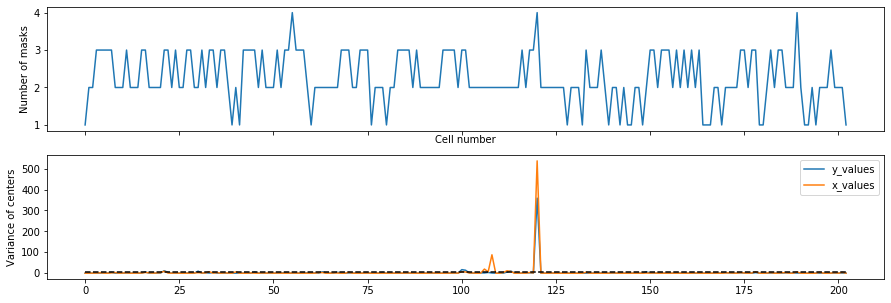

In [144]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = [15, 5])
ax[0].plot(n_planes)
ax[0].set_xlabel('Cell number')
ax[0].set_ylabel('Number of masks')
ax[1].plot(var_masks[:, 0], label = 'y_values')
ax[1].plot(var_masks[:, 1], label = 'x_values')
ax[1].set_ylabel('Variance of centers')
ax[1].plot(range(len(indices)), np.ones(len(indices))*8, '--', color = 'k')
ax[1].legend()

In [145]:
ind = np.nonzero(var_masks > 50)[0]

In [146]:
ind

array([108, 120, 120], dtype=int64)

In [147]:
cell_no = ind[2] + 1
masks = Cell.cell_data[cell_no]['masks']
masks

{14: array([[763.45916438, 911.99920008],
        [758.9540603 , 911.99920008],
        [756.79944531, 913.17444462],
        [755.23245258, 915.91668188],
        [755.23245258, 921.00940823],
        [755.82007485, 926.68975685],
        [759.54168257, 926.10213458],
        [762.47979393, 924.53514186],
        [765.61377937, 922.77227505],
        [767.37664619, 919.6382896 ],
        [767.96426846, 915.13318552],
        [767.57252028, 913.17444462]]),
 15: array([[799.6958711 , 865.38116656],
        [796.95363384, 866.16466292],
        [794.79901884, 868.51515201],
        [792.44852976, 870.08214473],
        [792.84027794, 874.19550063],
        [794.79901884, 876.9377379 ],
        [797.34538202, 878.30885653],
        [799.6958711 , 877.91710835],
        [801.65461201, 875.76249335],
        [803.61335291, 873.60787836],
        [805.18034563, 871.45326336],
        [805.18034563, 866.7522852 ],
        [804.78859745, 865.18529247],
        [804.00510109, 864.40179611]]),


In [120]:
Cell.cell_data.pop(cell_no)

{'cell_id': 30,
 'z_planes': [16, 17, 15],
 'masks': {16: array([[1080.85613872,  561.65899275],
         [1077.43598525,  561.45780725],
         [1074.21701728,  562.26254925],
         [1072.80871879,  564.87796072],
         [1076.22887226,  568.70048519],
         [1079.64902573,  572.32182416],
         [1081.86206621,  574.33367914],
         [1084.67866318,  574.13249364],
         [1086.48933267,  571.71826766],
         [1087.49526016,  568.29811419],
         [1086.69051816,  565.48151722],
         [1086.08696167,  564.27440423],
         [1085.48340517,  563.26847674]]),
  17: array([[1083.87392119,  563.06729124],
         [1079.24665473,  562.66492024],
         [1074.01583178,  562.86610574],
         [1070.79686381,  565.88388821],
         [1069.99212181,  568.70048519],
         [1072.0039768 ,  572.92538065],
         [1076.83242875,  574.93723563],
         [1080.45376772,  575.13842113],
         [1083.47155019,  574.53486464],
         [1085.68459067,  572.925380

## View saved masks in new napari window

In [326]:
# Open image in napari viewer - each channel as a separate layer 
viewer2 = napari.Viewer()

viewer2.add_image(im_array2[:, :, :], name = 'Channel {0}'.format(i + 1), colormap = 'viridis', 
                     interpolation = 'nearest')
    
indices = list(Cell.cell_data.keys())
viewer2.add_shapes(mask, shape_type = 'polygon', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)
mask_layer = viewer2.layers['Shapes']
for cell in indices:
    plane = Cell.cell_data[cell]['z_planes'][0]
    mask = Cell.cell_data[cell]['masks'][plane]
    mask_layer.add(mask, shape_type = 'polygon', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)


C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vis

In [303]:
mask_layer.add()

{1: {'cell_id': 1,
  'z_planes': [1],
  'masks': {1: array([[1203.88111044,  337.39930311],
          [1200.28185564,  338.59905471],
          [1197.08251804,  342.39826811],
          [1195.68280784,  345.19768851],
          [1199.28206264,  347.79715031],
          [1203.08127604,  349.59677772],
          [1206.88048944,  350.39661212],
          [1209.47995124,  348.99690192],
          [1211.47953724,  346.59739871],
          [1211.27957864,  342.99814391],
          [1208.48015824,  339.19893051],
          [1207.68032384,  338.19913751]])},
  'no_planes': 1,
  'c_vals': array([0.])},
 2: {'cell_id': 2,
  'z_planes': [1, 2],
  'masks': {1: array([[1211.33317027,  392.72244235],
          [1208.9794914 ,  393.21279212],
          [1208.48914163,  394.87998132],
          [1208.88142144,  398.41049963],
          [1209.96019093,  401.64680808],
          [1211.72545008,  403.41206723],
          [1214.17719891,  404.39276676],
          [1216.92315759,  405.47153624],
          